In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/home/kcv/Desktop/peak_power_test/stitched_detail_data/RD_LFP_PeakPower_REPT_TS_150_0001_0_100.csv')

In [3]:
df.columns

Index(['source_file', 'sheet_name', 'Record number', 'Sequence number of step',
       'Cycle No', 'Step No', 'Step name', 'Absolute time', 'Record time(m)',
       'Step time(h:m:s.ms)', 'volt(V)', 'Current(A)', 'Capacity(Ah)',
       'Energy(Wh)', 'Power(mW)', 'Internal R(Ω)', 'Charging energy(Wh)',
       'Discharge energy(Wh)', 'Charging capacity(Ah)',
       'Discharge capacity(Ah)', 'CUM charge E(Wh)', 'CUM discharge E(Wh)',
       'CUM charge C(Ah)', 'CUM discharge C(Ah)', 'Chamber T(℃)',
       'Chamber H(%)', 'Ripple F(Hz)', 'Ripple current(A)',
       'Total capacity(Ah)', 'DischargeVolt(V)', 'DischargeCurrent(A)',
       'DischargePower(mW)', 'water chiller outlet pressure(bar)',
       'water chiller return water pressure(bar)',
       'water chiller set flow(L/min)', 'water chiller set temperature(℃)',
       'Current water chiller temperature(℃)',
       'Current water chiller flow rate(L/min)', 'water chiller status',
       'water chiller mode', 'water chiller return wa

In [4]:
df[['Cycle No', 'Step name', 'Step No']].drop_duplicates()


,Cycle No,Step name,Step No
0,1,Rest,1
31,1,CC_Chg,2
403,1,Rest,3
464,1,CC_Chg,4
495,1,CC_Chg,5
579,1,Rest,6
640,1,CC_Chg,7
671,1,CC_Chg,8
745,1,Rest,9
806,1,CC_Chg,10


In [57]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("/home/kcv/Desktop/peak_power_test/stitched_detail_data")
OUTPUT = Path("/home/kcv/Desktop/peak_power_test/post_processing/data/eda_summary.csv")

summaries = []

for csv_path in sorted(DATA_DIR.glob("*.csv")):
    df = pd.read_csv(csv_path)

    df["Absolute time"] = pd.to_datetime(df["Absolute time"], errors="coerce")
    df["Current_abs_A"] = round(df["Current(A)"].abs(),2)
    df["Capacity_abs_Ah"] = df["Capacity(Ah)"].abs()
    df["Power_W"] = df["Power(mW)"].abs() / 1000

    df = df.sort_values(["Cycle No", "Absolute time", "Step No"])

    durations = (
        df.groupby(["Cycle No", "Step name", "Step No"], dropna=False)
          .agg(
              Start=("Absolute time", "min"),
              End=("Absolute time", "max"),
              Current_min=("Current_abs_A", "min"),
              Current_max=("Current_abs_A", "max"),
              Capacity_min=("Capacity_abs_Ah", "min"),
              Capacity_max=("Capacity_abs_Ah", "max"),
              Volt_min=("volt(V)", "min"),
              Volt_max=("volt(V)", "max"),
              Power_min_W=("Power_W", "min"),
              Power_max_W=("Power_W", "max"),
          )
    )

    durations["Duration_s"] = (durations["End"] - durations["Start"]).dt.total_seconds().round()
    durations["c_rate"] = (durations["Current_max"] / 150).round(3)

    summary = durations.reset_index()
    summary.insert(0, "Cell", csv_path.stem)
    summaries.append(summary)

eda_summary = pd.concat(summaries, ignore_index=True)
eda_summary.to_csv(OUTPUT, index=False)
print(f"Saved summary for {len(summaries)} cells to {OUTPUT}")


Saved summary for 21 cells to /home/kcv/Desktop/peak_power_test/post_processing/data/eda_summary.csv


In [2]:
from utils.step_boxplots import create_step_boxplots

for param in ["Power_max_W","Volt_max","Duration_s"]:

    create_step_boxplots(
        value_col=param,  # or "Power_max_W", etc.
        output_dir="/home/kcv/Desktop/peak_power_test/post_processing/plots",
    )


Saved combined boxplots to /home/kcv/Desktop/peak_power_test/post_processing/plots/Power_max_W_charge_discharge_boxplot.png
Saved combined heatmap to /home/kcv/Desktop/peak_power_test/post_processing/plots/Power_max_W_charge_discharge_heatmap.png
Saved combined boxplots to /home/kcv/Desktop/peak_power_test/post_processing/plots/Volt_max_charge_discharge_boxplot.png
Saved combined heatmap to /home/kcv/Desktop/peak_power_test/post_processing/plots/Volt_max_charge_discharge_heatmap.png
Saved combined boxplots to /home/kcv/Desktop/peak_power_test/post_processing/plots/Duration_s_charge_discharge_boxplot.png
Saved combined heatmap to /home/kcv/Desktop/peak_power_test/post_processing/plots/Duration_s_charge_discharge_heatmap.png


In [38]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("/home/kcv/Desktop/peak_power_test/stitched_detail_data")
OUTPUT_DIR = Path("/home/kcv/Desktop/peak_power_test/post_processing/data")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

REQUIRED_COLUMNS = [
    "Cycle No",
    "Step No",
    "Step name",
    "Absolute time",
    "Record time(m)",
    "Step time(h:m:s.ms)",
    "volt(V)",
    "Current(A)",
    "Capacity(Ah)",
    "Energy(Wh)",
    "Power(mW)",
    "c-rate",
    "duration",
]

for csv_path in DATA_DIR.glob("*.csv"):
    df = pd.read_csv(csv_path)

    if not {"Absolute time", "Current(A)", "Cycle No", "Step No", "Step name"} <= set(df.columns):
        raise ValueError(f"{csv_path.name} is missing required source columns.")

    df["Absolute time"] = pd.to_datetime(df["Absolute time"], errors="coerce")

    df["c-rate"] = (df["Current(A)"].abs() / 150).round(3)

    df["duration"] = (
        df.groupby(["Cycle No", "Step No", "Step name"])["Absolute time"]
          .transform(lambda s: (s.max() - s.min()).total_seconds())
    )

    missing = [col for col in REQUIRED_COLUMNS if col not in df.columns]
    if missing:
        raise ValueError(f"{csv_path.name} lacks columns: {', '.join(missing)}")

    df = df[REQUIRED_COLUMNS]
    df.to_csv(OUTPUT_DIR / csv_path.name, index=False)
    print(f"Saved {csv_path.name} with c-rate and duration.")


Saved RD_LFP_PeakPower_REPT_TS_150_0007_0_100.csv with c-rate and duration.
Saved RD_LFP_PeakPower_REPT_TS_150_0046_0_100.csv with c-rate and duration.
Saved RD_LFP_PeakPower_REPT_TS_150_0050_0_100.csv with c-rate and duration.
Saved RD_LFP_PeakPower_REPT_TS_150_0049_0_100.csv with c-rate and duration.
Saved RD_LFP_PeakPower_REPT_TS_150_0025_0_100.csv with c-rate and duration.
Saved RD_LFP_PeakPower_REPT_TS_150_0074_0_100.csv with c-rate and duration.
Saved RD_LFP_PeakPower_REPT_TS_150_0090_0_100.csv with c-rate and duration.
Saved RD_LFP_PeakPower_REPT_TS_150_0080_0_100.csv with c-rate and duration.
Saved RD_LFP_PeakPower_REPT_TS_150_0087_0_100.csv with c-rate and duration.
Saved RD_LFP_PeakPower_REPT_TS_150_0011_0_100.csv with c-rate and duration.
Saved RD_LFP_PeakPower_REPT_TS_150_0012_0_100.csv with c-rate and duration.
Saved RD_LFP_PeakPower_REPT_TS_150_0003_0_100.csv with c-rate and duration.
Saved RD_LFP_PeakPower_REPT_TS_150_0004_0_100.csv with c-rate and duration.
Saved RD_LFP

In [16]:
import pandas as pd

summary_path = "/home/kcv/Desktop/peak_power_test/post_processing/data/eda_summary.csv"

eda = pd.read_csv(summary_path)

mask = (
    eda["Cell"].str.contains("_0049_0_100") &
    eda["Step No"].isin([38, 41])
)

durations = eda.loc[mask, ["Step No", "Duration_s"]]
print(durations)


     Step No  Duration_s
672       38        29.0
674       41        29.0


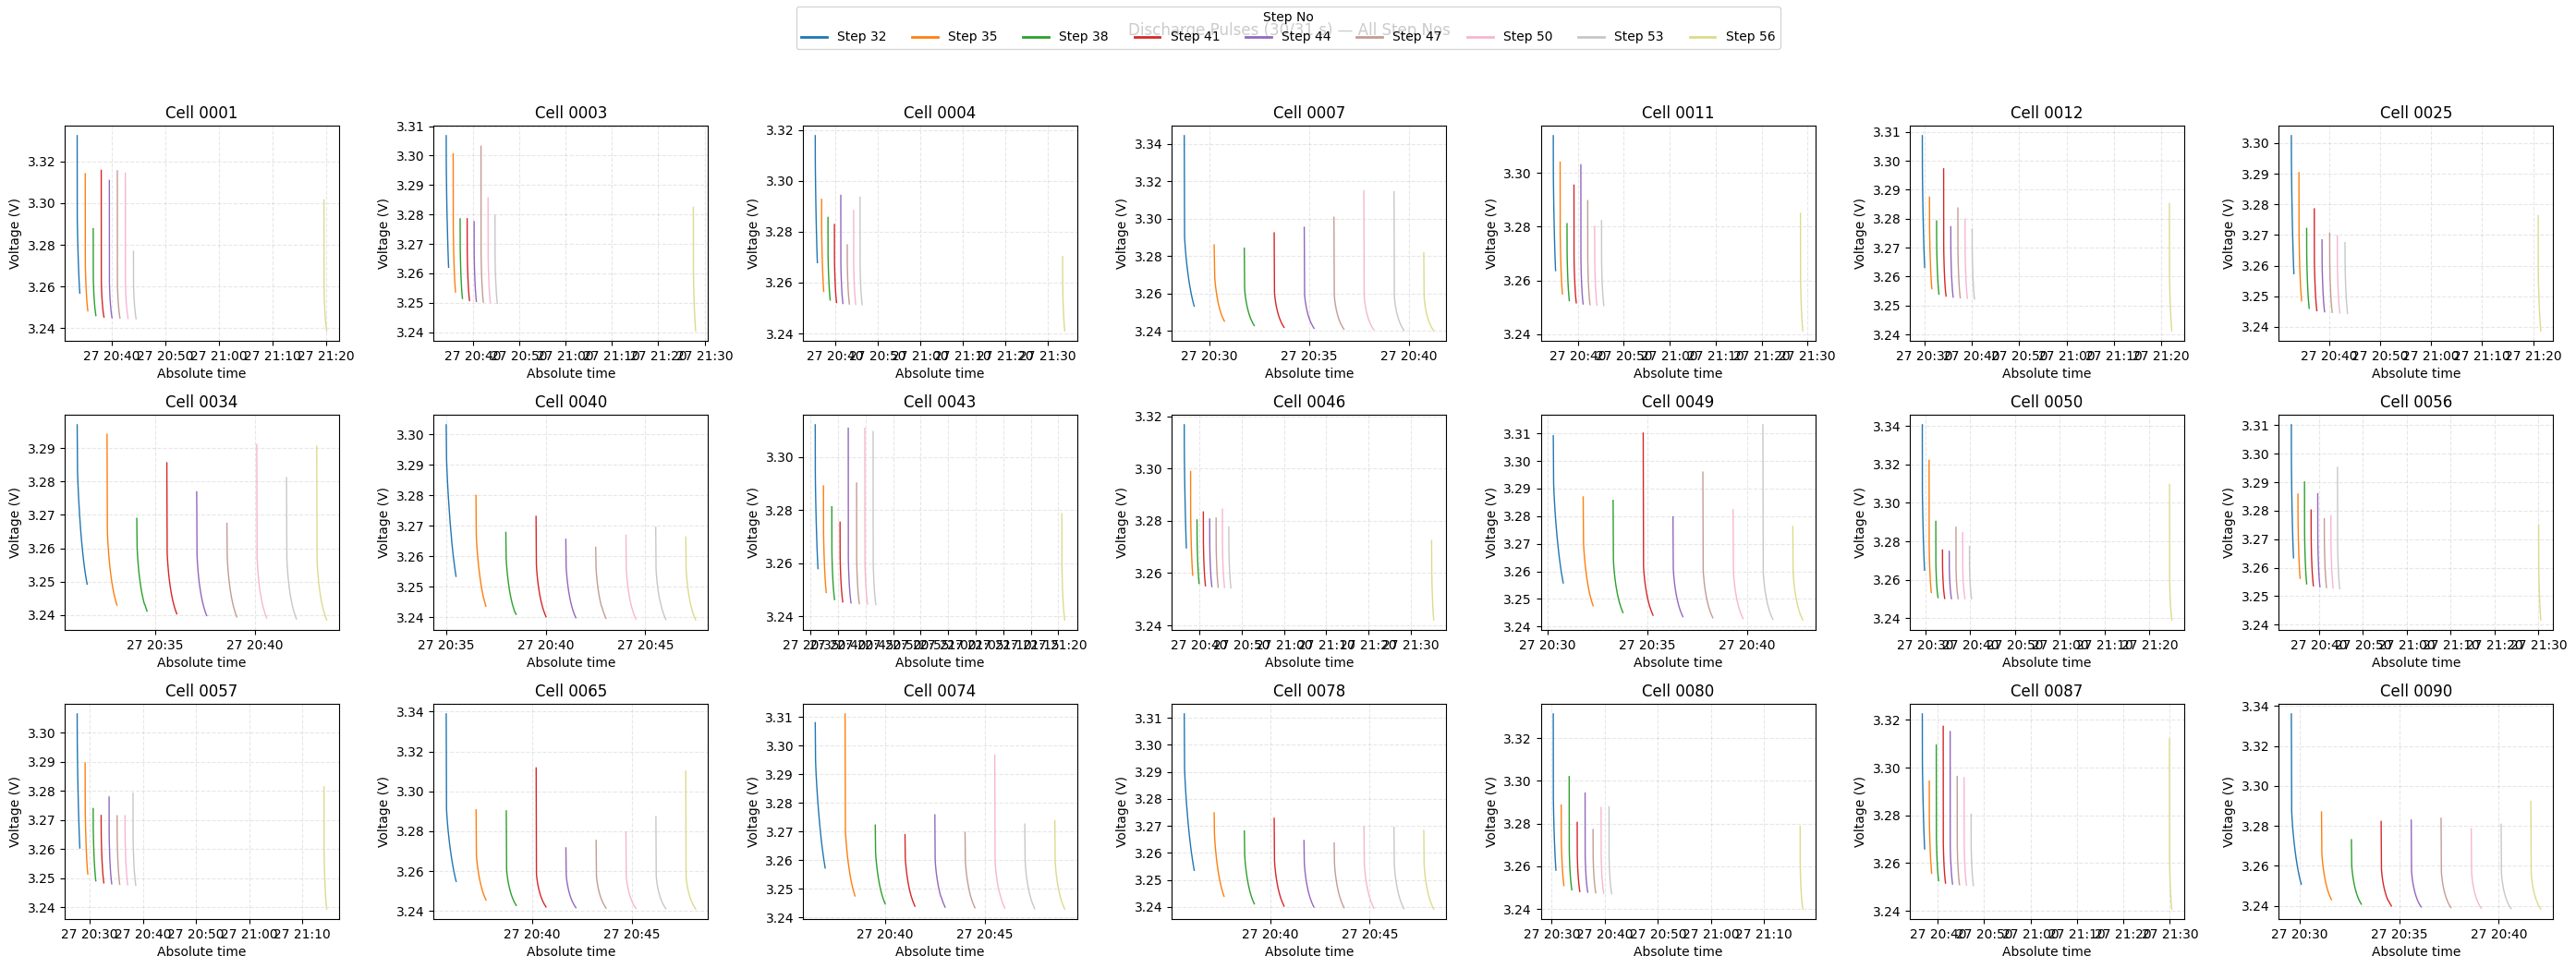

In [18]:
import math
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

DATA_DIR = Path("/home/kcv/Desktop/peak_power_test/post_processing/data")

def cell_id(name: str) -> str:
    match = re.search(r"_(\d{4})(?:_0_100)?$", name)
    return match.group(1) if match else name

cell_traces = []
all_steps = set()

for csv_path in sorted(DATA_DIR.glob("*.csv")):
    if csv_path.name == "eda_summary.csv":
        continue

    df = pd.read_csv(csv_path)
    df["Absolute time"] = pd.to_datetime(df["Absolute time"], errors="coerce")
    df = df.dropna(subset=["Absolute time"])
    df = df[df["duration"].round().isin([29, 30, 31])]
    subset = df[df["Step name"].str.contains("DChg", case=False)]
    if subset.empty:
        continue

    cell_traces.append((cell_id(csv_path.stem), subset))
    all_steps.update(subset["Step No"].unique())

if not cell_traces:
    raise ValueError("No discharge pulses with 30/31 s duration found.")

all_steps = sorted(all_steps)
colors = plt.colormaps["tab20"](np.linspace(0, 1, len(all_steps), endpoint=False))
global_palette = dict(zip(all_steps, colors))

n_cells = len(cell_traces)
n_rows = 3
n_cols = math.ceil(n_cells / n_rows)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows))
axes = np.array(axes).reshape(n_rows, n_cols)

for ax in axes.flat[n_cells:]:
    ax.remove()

for (cid, subset), ax in zip(cell_traces, axes.flatten()):
    for step_no, group in subset.groupby("Step No"):
        ax.plot(
            group["Absolute time"],
            group["volt(V)"],
            label=f"Step {step_no}",
            color=global_palette.get(step_no, "black"),
            linewidth=1,
        )
    ax.set_title(f"Cell {cid}")
    ax.set_xlabel("Absolute time")
    ax.set_ylabel("Voltage (V)")
    ax.grid(alpha=0.3, linestyle="--")

handles = [
    plt.Line2D([0], [0], color=global_palette[step], lw=2, label=f"Step {step}")
    for step in all_steps
]
fig.legend(handles=handles, title="Step No", loc="upper center", ncol=min(len(all_steps), 10))
fig.suptitle("Discharge Pulses (30/31 s) — All Step Nos")
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


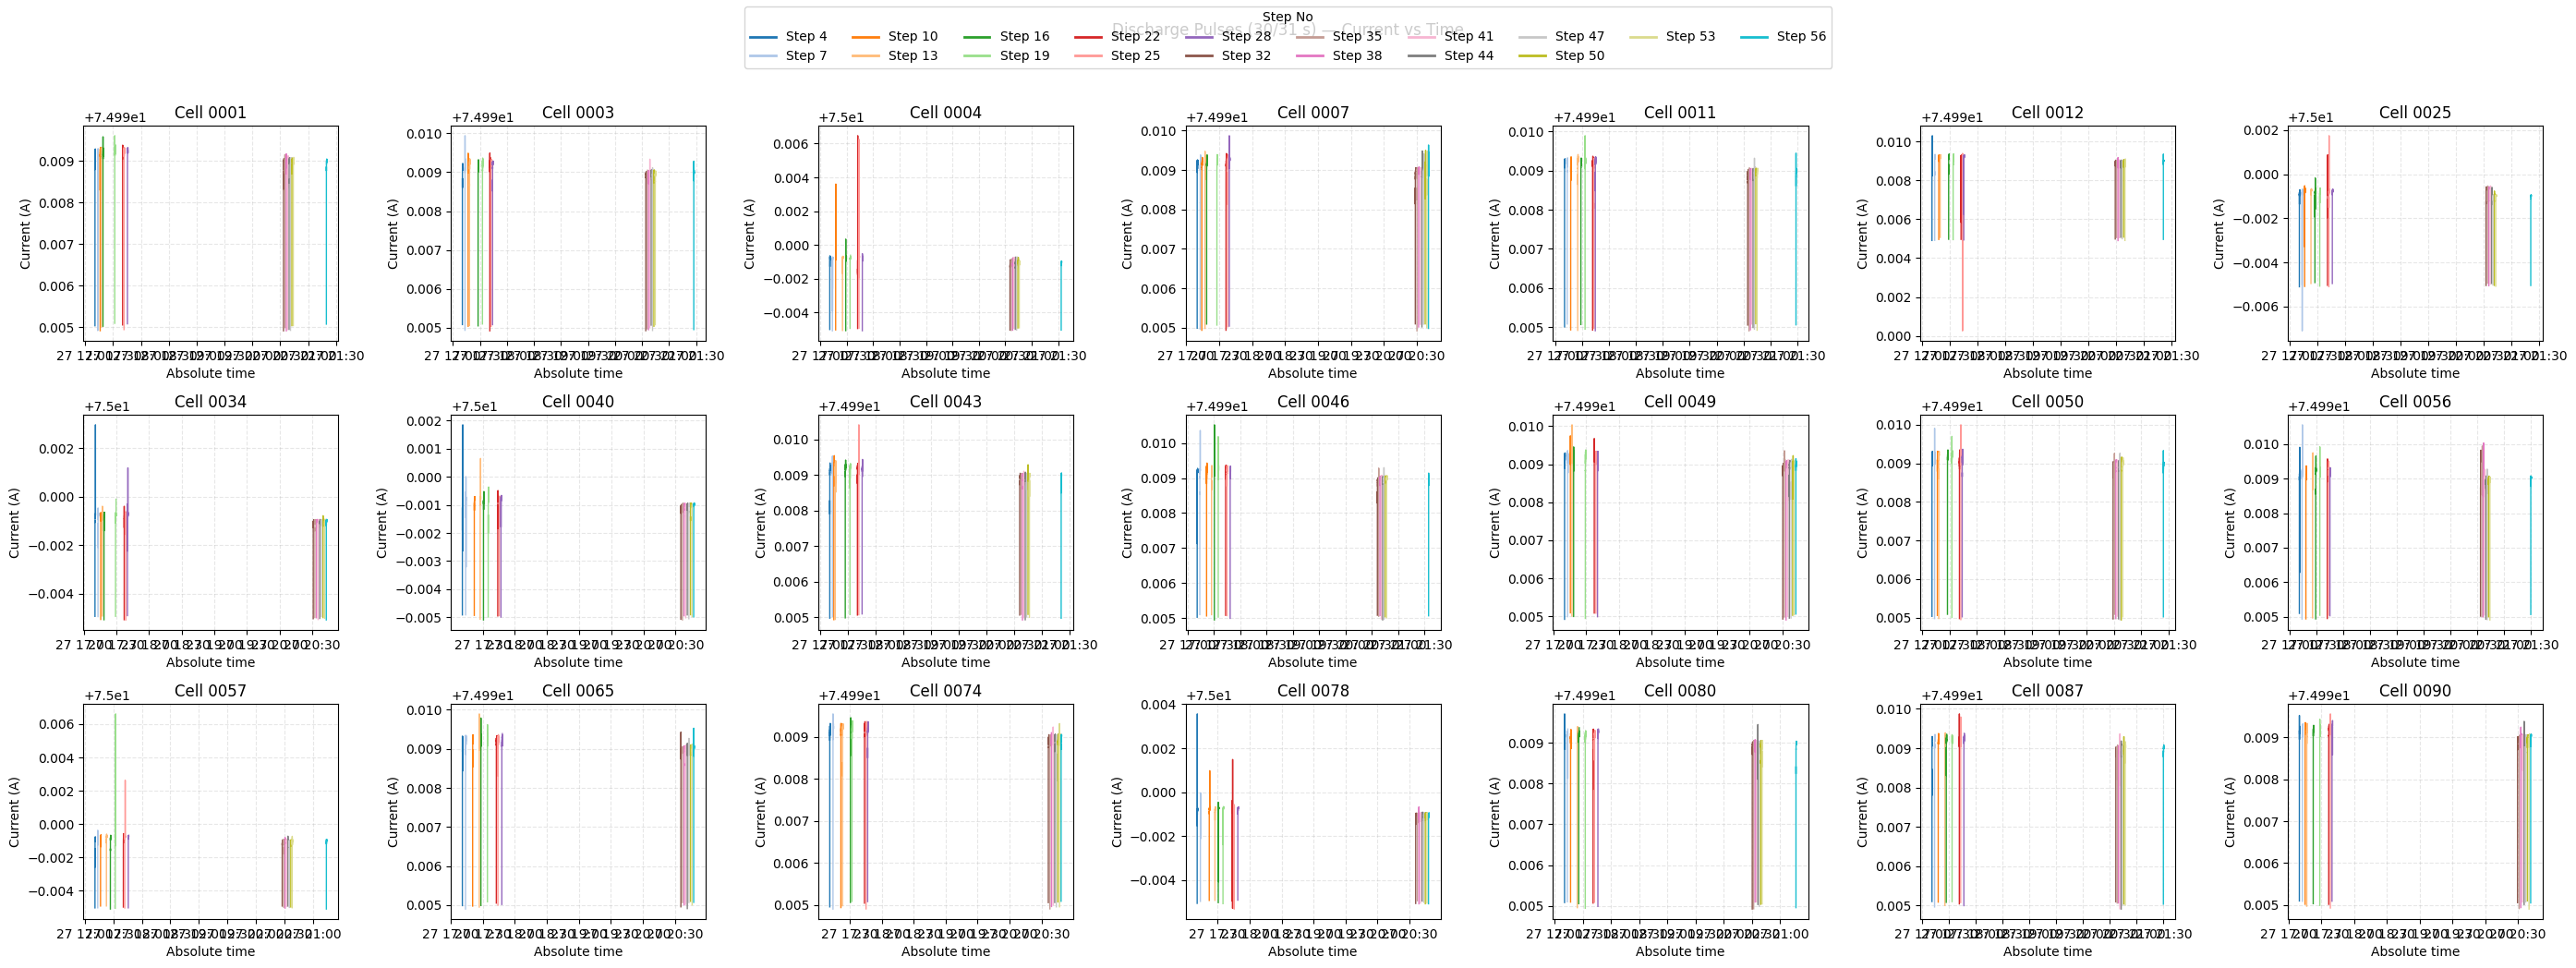

In [19]:
import math
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

DATA_DIR = Path("/home/kcv/Desktop/peak_power_test/post_processing/data")

def cell_id(name: str) -> str:
    match = re.search(r"_(\d{4})(?:_0_100)?$", name)
    return match.group(1) if match else name

cell_traces = []
all_steps = set()

for csv_path in sorted(DATA_DIR.glob("*.csv")):
    if csv_path.name == "eda_summary.csv":
        continue

    df = pd.read_csv(csv_path)
    df["Absolute time"] = pd.to_datetime(df["Absolute time"], errors="coerce")
    df = df.dropna(subset=["Absolute time"])
    df = df[df["duration"].round().isin([29, 30, 31])]
    subset = df[df["Step name"].str.contains("Chg", case=False)]
    if subset.empty:
        continue

    cell_traces.append((cell_id(csv_path.stem), subset))
    all_steps.update(subset["Step No"].unique())

if not cell_traces:
    raise ValueError("No discharge pulses with 30/31 s duration found.")

all_steps = sorted(all_steps)
colors = plt.colormaps["tab20"](np.linspace(0, 1, len(all_steps), endpoint=False))
global_palette = dict(zip(all_steps, colors))

n_cells = len(cell_traces)
n_rows = 3
n_cols = math.ceil(n_cells / n_rows)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows))
axes = np.array(axes).reshape(n_rows, n_cols)

for ax in axes.flat[n_cells:]:
    ax.remove()

for (cid, subset), ax in zip(cell_traces, axes.flatten()):
    for step_no, group in subset.groupby("Step No"):
        ax.plot(
            group["Absolute time"],
            abs(group["Current(A)"]),
            label=f"Step {step_no}",
            color=global_palette.get(step_no, "black"),
            linewidth=1,
        )

    ax.set_title(f"Cell {cid}")
    ax.set_xlabel("Absolute time")
    ax.set_ylabel("Current (A)")
    ax.grid(alpha=0.3, linestyle="--")

handles = [
    plt.Line2D([0], [0], color=global_palette[step], lw=2, label=f"Step {step}")
    for step in all_steps
]
fig.legend(handles=handles, title="Step No", loc="upper center", ncol=min(len(all_steps), 10))
fig.suptitle("Discharge Pulses (30/31 s) — Current vs Time")
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


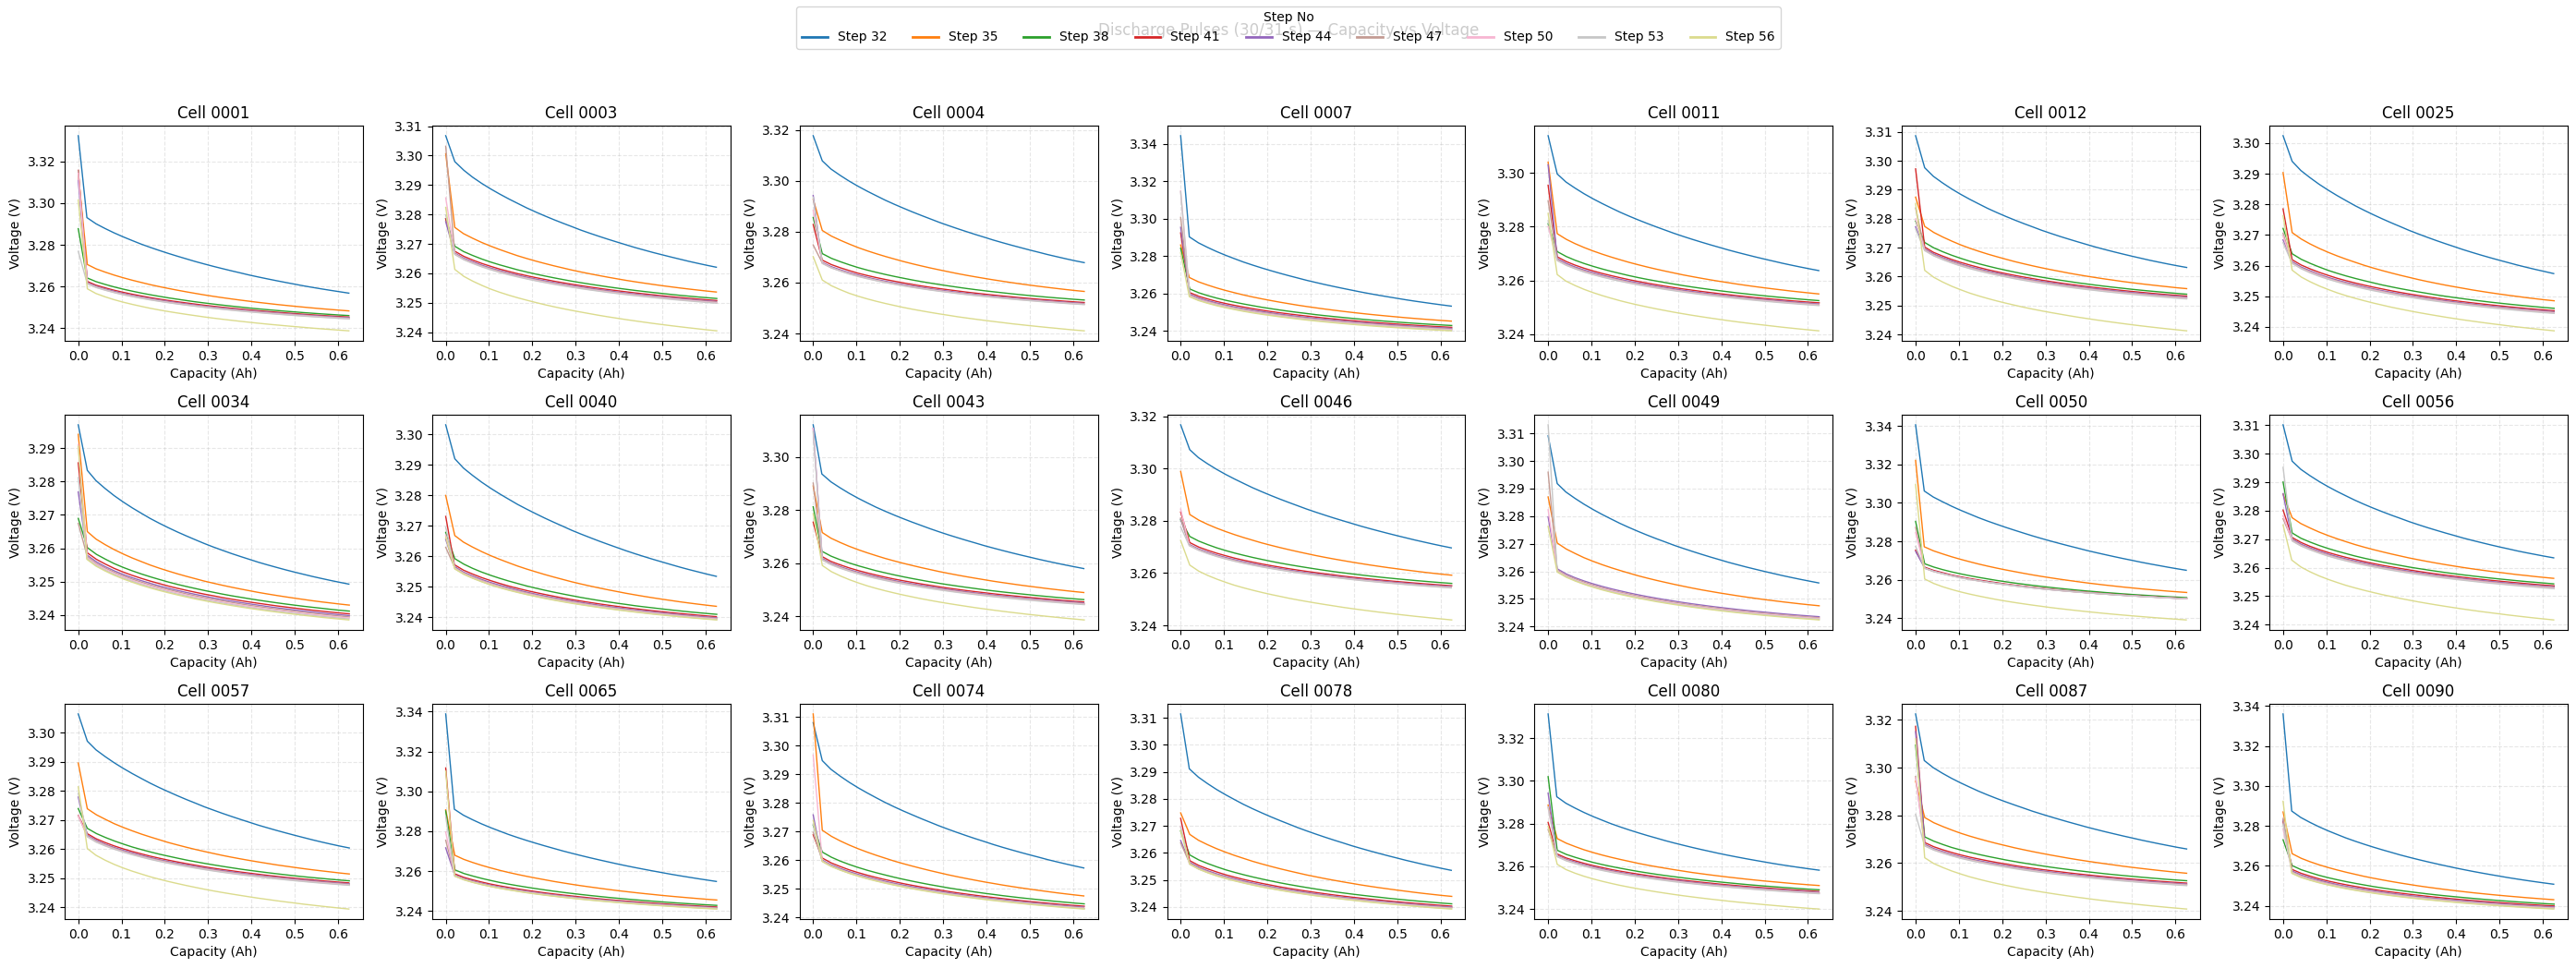

In [ ]:
import math
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

DATA_DIR = Path("/home/kcv/Desktop/peak_power_test/post_processing/data")

def cell_id(name: str) -> str:
    match = re.search(r"_(\d{4})(?:_0_100)?$", name)
    return match.group(1) if match else name

cell_traces = []
all_steps = set()

for csv_path in sorted(DATA_DIR.glob("*.csv")):
    if csv_path.name == "eda_summary.csv":
        continue

    df = pd.read_csv(csv_path)
    df["Absolute time"] = pd.to_datetime(df["Absolute time"], errors="coerce")
    df = df.dropna(subset=["Absolute time"])
    df = df[df["duration"].round().isin([29, 30, 31])]

    subset = df[df["Step name"].str.contains("DChg", case=False)]
    if subset.empty:
        continue

    cell_traces.append((cell_id(csv_path.stem), subset))
    all_steps.update(subset["Step No"].unique())

if not cell_traces:
    raise ValueError("No discharge pulses with 30/31 s duration found.")

all_steps = sorted(all_steps)
colors = plt.colormaps["tab20"](np.linspace(0, 1, len(all_steps), endpoint=False))
global_palette = dict(zip(all_steps, colors))

n_cells = len(cell_traces)
n_rows = 3
n_cols = math.ceil(n_cells / n_rows)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows))
axes = np.array(axes).reshape(n_rows, n_cols)

for ax in axes.flat[n_cells:]:
    ax.remove()

for (cid, subset), ax in zip(cell_traces, axes.flatten()):
    for step_no, group in subset.groupby("Step No"):
        ax.plot(
            abs(group["Capacity(Ah)"]),
            group["volt(V)"],
            
            label=f"Step {step_no}",
            color=global_palette.get(step_no, "black"),
            linewidth=1,
        )
    ax.set_title(f"Cell {cid}")
    ax.set_ylabel("Voltage (V)")
    ax.set_xlabel("Capacity (Ah)")
    ax.grid(alpha=0.3, linestyle="--")

handles = [
    plt.Line2D([0], [0], color=global_palette[step], lw=2, label=f"Step {step}")
    for step in all_steps
]
fig.legend(handles=handles, title="Step No", loc="upper center", ncol=min(len(all_steps), 10))
fig.suptitle("Discharge Pulses (30/31 s) — Capacity vs Voltage")
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


In [20]:
from __future__ import annotations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

DATA_DIR = Path("/home/kcv/Desktop/peak_power_test/post_processing/data")
OUTPUT_DIR = Path("/home/kcv/Desktop/peak_power_test/post_processing/plots")
OUTPUT_PDF = OUTPUT_DIR / "power_vs_time_matplotlib.pdf"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


def color_map_for_steps(summary: pd.DataFrame) -> dict[int, tuple]:
    """Use Viridis for 30 s steps (scaled by |P|max), grey elsewhere."""
    colors: dict[int, tuple] = {}
    viridis_steps = summary.index[(summary["duration"].round() == 29)|(summary["duration"].round() == 30)|(summary["duration"].round() == 31)]

    if not viridis_steps.empty:
        powers = summary.loc[viridis_steps, "max_power_W"]
        if powers.max() == powers.min():
            normalized = np.full(len(powers), 0.5)
        else:
            normalized = (powers - powers.min()) / (powers.max() - powers.min())
        cmap = plt.colormaps["viridis"]
        for step_no, val in zip(viridis_steps, normalized):
            colors[step_no] = cmap(val)

    grey = (0.6, 0.6, 0.6, 0.9)
    for step_no in summary.index:
        colors.setdefault(step_no, grey)

    return colors


def main() -> None:
    with PdfPages(OUTPUT_PDF) as pdf:
        for csv_path in sorted(DATA_DIR.glob("*.csv")):
            if csv_path.name == "eda_summary.csv":
                continue

            df = pd.read_csv(csv_path)
            df["Absolute time"] = pd.to_datetime(df["Absolute time"], errors="coerce")
            df = df.dropna(subset=["Absolute time"])

            for step_name, step_df in df.groupby("Step name"):
                step_df = step_df.sort_values("Absolute time")

                summary = (
                    step_df.groupby("Step No")
                    .agg(
                        max_power_W=("Power(mW)", lambda s: s.abs().max() / 1000),
                        duration=("duration", "max"),
                        c_rate=("c-rate", "max"),
                    )
                )

                colors = color_map_for_steps(summary)

                fig, ax = plt.subplots(figsize=(10, 6))
                for step_no, group in step_df.groupby("Step No"):
                    color = colors.get(step_no, (0.6, 0.6, 0.6, 0.9))
                    label = (
                        f"Step {step_no} | "
                        f"{summary.loc[step_no, 'c_rate']:.3f}C | "
                        f"{summary.loc[step_no, 'max_power_W']:.2f} W | "
                        f"{summary.loc[step_no, 'duration']:.0f}s"
                    )
                    ax.scatter(
                        group["Absolute time"],
                        abs(group["Power(mW)"]),
                        s=5,
                        alpha=0.85,
                        label=label,
                        color=color,
                    )

                ax.set_title(f"Power vs Absolute Time — {csv_path.stem} — {step_name}")
                ax.set_xlabel("Absolute time")
                ax.set_ylabel("Power (mW)")
                ax.legend(fontsize="small", loc="upper right", bbox_to_anchor=(1.0, 1.0))
                ax.grid(True, linestyle="--", alpha=0.3)
                plt.tight_layout()
                pdf.savefig(fig)
                plt.close(fig)

    print(f"Saved multi-page PDF to {OUTPUT_PDF}")


if __name__ == "__main__":
    main()


Saved multi-page PDF to /home/kcv/Desktop/peak_power_test/post_processing/plots/power_vs_time_matplotlib.pdf


In [3]:
from utils.plot_charge_discharge import generate_chg_dchg_plots
generate_chg_dchg_plots(
    data_dir="/home/kcv/Desktop/peak_power_test/post_processing/data",
    output_dir="/home/kcv/Desktop/peak_power_test/post_processing/plots",
    x_field="Absolute time",
    y_fields=("Power(mW)",),   # note the tuple
    output_filename="chg_dchg_power_vs_time.pdf",
)


Saved charge/discharge plots to /home/kcv/Desktop/peak_power_test/post_processing/plots/chg_dchg_power_vs_time.pdf


PosixPath('/home/kcv/Desktop/peak_power_test/post_processing/plots/chg_dchg_power_vs_time.pdf')

In [4]:
generate_chg_dchg_plots(
    data_dir="/home/kcv/Desktop/peak_power_test/post_processing/data",
    output_dir="/home/kcv/Desktop/peak_power_test/post_processing/plots",
    x_field="Absolute time",
    y_fields=("volt(V)",),   # note the tuple
    output_filename="chg_dchg_voltage_vs_time.pdf",
)

Saved charge/discharge plots to /home/kcv/Desktop/peak_power_test/post_processing/plots/chg_dchg_voltage_vs_time.pdf


PosixPath('/home/kcv/Desktop/peak_power_test/post_processing/plots/chg_dchg_voltage_vs_time.pdf')